The Best

In [8]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import train_test_split
import random
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

class Client:

    def __init__(self, model = None) -> None:
        self.model = model

    # Treinamento local de cada cliente. Recebe as entradas de treinamento (Xi,yi).
    def trainLocal(self,Xi,yi):

        # Peso de cada cliente a ser usado na modelagem de Weighted FedAvg. Clientes com mais entradas têm peso maior.
        self.client_weight = len(Xi)

        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        # Treinando o modelo
        self.model.fit(Xi, yi, epochs=1, batch_size=32, verbose=0)

    # Modelo a ser recebido do servidor, após agregação dos modelos.
    def receiveModel(self,new_model):
        self.model = new_model

class Server:

    def __init__(self, model = None) -> None:
        self.model = model

    # Agrega os pesos dos modelos dos clientes no servidor.
    def aggregate(self, clients):

        clients_wgs = [client.client_weight for client in clients]
        clients_wgs_norm = np.array(clients_wgs) / np.sum(clients_wgs)

        # wgs_1 = [client.model.get_weights()[0] * wgs_norm for client,wgs_norm in zip(clients,clients_wgs_norm)] # layer 1
        # bss_1 = [client.model.get_weights()[1] * wgs_norm for client,wgs_norm in zip(clients,clients_wgs_norm)] # layer 1
        # wgs_2 = [client.model.get_weights()[2] * wgs_norm for client,wgs_norm in zip(clients,clients_wgs_norm)] # layer 2
        # bss_2 = [client.model.get_weights()[3] * wgs_norm for client,wgs_norm in zip(clients,clients_wgs_norm)] # layer 2

        # weights = [np.sum(wgs_1,axis=0),np.sum(bss_1,axis=0),np.sum(wgs_2,axis=0),np.sum(bss_2,axis=0)]

        # [[c0w0,c0w1,c0w2,c0w3],[c1w0,c1w1,c1w2,c1w3],[c2w0,...],...]. Para cada camada são 2 tipos de pesos considerados: weights e biases.
        wbs = [[client.model.get_weights()[i] * wgs_norm for i in range(len(2*client.model.layers))] for client,wgs_norm in zip(clients,clients_wgs_norm)]
        # [sum(c0w0,c1w0,...cnw0),sum(c0w1,c1w1,...cnw1),...,sum(c0wm,c1wm,...cnwm)]. Mantém a ordem: pesos,biases,pesos,biases,...
        weights = [np.sum(z,axis=0) for z in zip(*wbs)]

        self.model.set_weights(weights)

        return self.model

    # Envia o modelo de pesos agregados de volta para cada cliente.
    def sendModel(self,clients_list, new_model):
        for client in clients_list:
            client.receiveModel(new_model)

(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Pré-processamento dos dados
X_train = X_train.reshape((60000, 28 * 28))
X_train = X_train.astype('float32') / 255

X_test = X_test.reshape((10000, 28 * 28))
X_test = X_test.astype('float32') / 255

y_train = to_categorical(y_train)  # Convertendo rótulos para one-hot encoding
y_test = to_categorical(y_test)    # Convertendo rótulos para one-hot encoding

# NCLIENTS: Número de clientes (ativos e inativos) no aprendizado federado
# PROBFAIL: (0<=p<=1) Probabilidade de falha de cada cliente
# ROUNDS: Rodadas de Aprendizado Federado
# OVERLAPPING_ENTRIES_PERCENT: (0<=p<=1) Percentual de overlap no treinamento não aleatório
# RANDOM_TRAINING_ENTRIES: (True/False) Clientes com conjuntos de treino totalmente aleatórios
# CHAOTIC_ENTRIES: Até quantos elementos poderão ter os conjuntos aleatórios de treinamento de cada cliente
# TRAIN_SIZE: tamanho do conjunto dos dados de treino
# TEST_SIZE: tamanho do conjunto dos dados de teste

def FL(NCLIENTS,ROUNDS,PROBFAIL,OVERLAPPING_ENTRIES_PERCENT,RANDOM_TRAINING_ENTRIES,CHAOTIC_ENTRIES,TRAIN_SIZE,TEST_SIZE):

    model = Sequential()
    model.add(Dense(units=32, activation='relu', input_dim=784))
    # model.add(Dense(units=64, activation='relu'))
    # model.add(Dense(units=128, activation='relu'))
    # model.add(Dense(units=64, activation='relu'))
    # model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=10, activation='softmax'))

    clients = {}

    # Inicialização dos clientes
    for n in range(NCLIENTS):
        clients[f"c{n}"] = Client()

    # Inicialização do servidor
    s = Server(model)

    # Lista dos objetos clientes
    clients_list = [v for k,v in clients.items()]
    print(f"Total clients: {len(clients)} total.")

    # Servidor envia o modelo para os clientes - model sync
    s.sendModel(clients_list,s.model)

    rounds = []
    global_accuracies = []
    global_losses = []

    # Rodadas de Aprendizado Federado
    for round in range(ROUNDS):

        print(f"------Round {round}------")

        # Clientes ativos no aprendizado federado
        clients_list = [v for k,v in clients.items() if PROBFAIL <= random.uniform(0, 1)]
        
        print(f"Active clients: {len(clients_list)} / {len(clients)} total.")

        try:
            if RANDOM_TRAINING_ENTRIES == False:
                for i,c in enumerate(clients_list):
                    partition = TRAIN_SIZE // len(clients_list)
                    Xi = X_train[i * partition : (i+1) * partition + int(OVERLAPPING_ENTRIES_PERCENT * partition)]
                    yi = y_train[i * partition : (i+1) * partition + int(OVERLAPPING_ENTRIES_PERCENT * partition)]
                    c.trainLocal(Xi,yi)
            else:
                for i,c in enumerate(clients_list):
                    # De 1 a 60000 entradas, selecionar até CHAOTIC_ENTRIES aleatoriamente para treinamento
                    samples = random.sample(range(1, len(X_train)), random.randint(1, CHAOTIC_ENTRIES))
                    print(f"Training client {i} with {len(samples)} samples")
                    Xi = X_train[samples]
                    yi = y_train[samples]
                    c.trainLocal(Xi,yi)
                    

            # Clientes enviam seus modelos treinados de volta ao servidor - upload - e o servidor agrega os modelos
            global_model = s.aggregate(clients_list) 

            # Servidor envia o modelo agregado de volta aos clientes - model sync
            s.sendModel(clients_list,global_model)

            # Acurácia e perda globais (modelo agregado).
            loss, acc = global_model.evaluate(X_test[:TEST_SIZE], y_test[:TEST_SIZE], verbose=0)
            print(f"Round {round}.GLOBAL ACC: {acc}")

            rounds.append(round)
            global_losses.append(loss)
            global_accuracies.append(acc)
        except Exception as e:
            # Se não houver clientes ativos na rodada, o desempenho de loss e acc deve ser igual ao último desempenho obtido
            print(e)
            print("All clients disconnected.Waiting connection...")
            rounds.append(round)

            if round == 0:
                global_losses.append(0)
                global_accuracies.append(0)
            else:
                previous_loss = global_losses[round - 1]
                previous_accuracy = global_losses[round - 1]

                global_losses.append(previous_loss)
                global_accuracies.append(previous_accuracy)
            continue

    return rounds,global_accuracies, global_losses

Total clients: 3 total.
------Round 0------
Active clients: 3 / 3 total.
Round 0.GLOBAL ACC: 0.4866666793823242
------Round 1------
Active clients: 3 / 3 total.
Round 1.GLOBAL ACC: 0.6366666555404663
------Round 2------
Active clients: 3 / 3 total.
Round 2.GLOBAL ACC: 0.7233333587646484
------Round 3------
Active clients: 3 / 3 total.
Round 3.GLOBAL ACC: 0.7833333611488342
------Round 4------
Active clients: 3 / 3 total.
Round 4.GLOBAL ACC: 0.8199999928474426
------Round 5------
Active clients: 3 / 3 total.
Round 5.GLOBAL ACC: 0.8333333134651184
------Round 6------
Active clients: 3 / 3 total.
Round 6.GLOBAL ACC: 0.8533333539962769
------Round 7------
Active clients: 3 / 3 total.
Round 7.GLOBAL ACC: 0.8500000238418579
------Round 8------
Active clients: 3 / 3 total.
Round 8.GLOBAL ACC: 0.8566666841506958
------Round 9------
Active clients: 3 / 3 total.
Round 9.GLOBAL ACC: 0.8666666746139526
Total clients: 6 total.
------Round 0------
Active clients: 6 / 6 total.
Round 0.GLOBAL ACC: 0.5

C:\Users\lucas\AppData\Local\Temp\ipykernel_106884\886731852.py:24: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([l1, l2, l3],     # The line objects


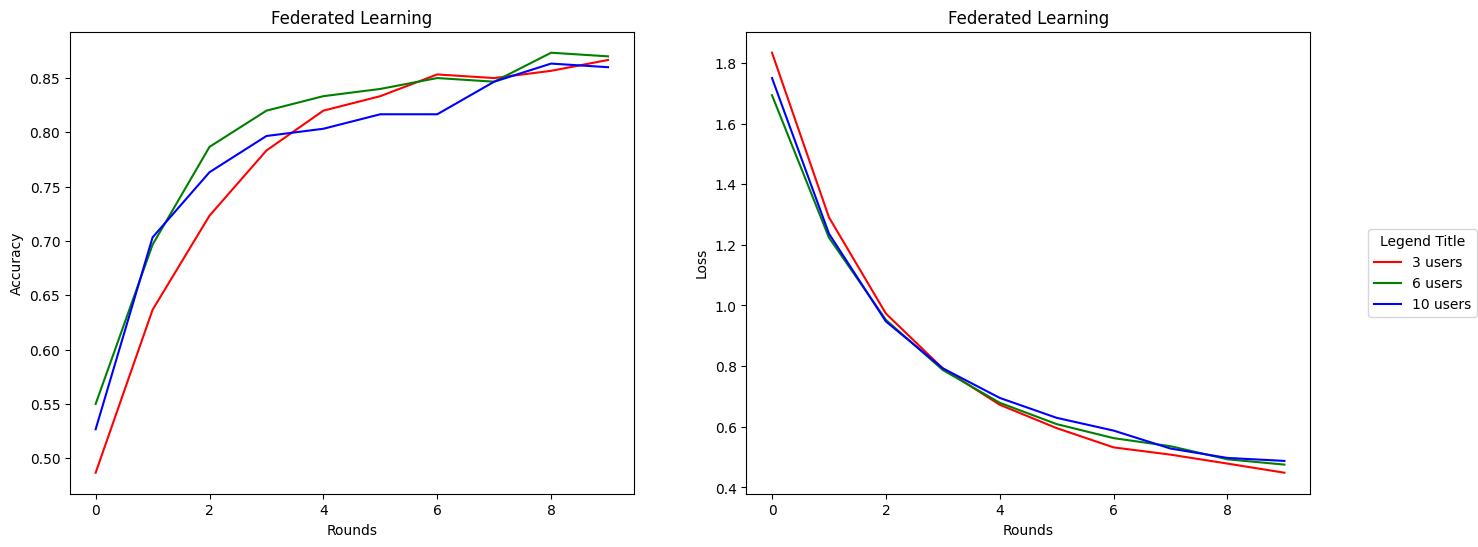

In [3]:
r1, ga1, gl1 = FL(NCLIENTS=3,ROUNDS=10,PROBFAIL=0,OVERLAPPING_ENTRIES_PERCENT=0,RANDOM_TRAINING_ENTRIES=False,CHAOTIC_ENTRIES=40,TRAIN_SIZE=700,TEST_SIZE=300)
r2, ga2, gl2 = FL(NCLIENTS=6,ROUNDS=10,PROBFAIL=0,OVERLAPPING_ENTRIES_PERCENT=0,RANDOM_TRAINING_ENTRIES=False,CHAOTIC_ENTRIES=40,TRAIN_SIZE=700,TEST_SIZE=300)
r3, ga3, gl3 = FL(NCLIENTS=10,ROUNDS=10,PROBFAIL=0,OVERLAPPING_ENTRIES_PERCENT=0,RANDOM_TRAINING_ENTRIES=False,CHAOTIC_ENTRIES=40,TRAIN_SIZE=700,TEST_SIZE=300)


fig, axs = plt.subplots(1,2, figsize=(16,6))
line_labels = ['3 users','6 users','10 users']

axs[0].title.set_text(f'Federated Learning')
axs[0].set_xlabel('Rounds')
axs[0].set_ylabel('Accuracy')
l1 = axs[0].plot(r1,ga1, color='red')[0]
l2 = axs[0].plot(r2,ga2, color='green')[0]
l3 = axs[0].plot(r3,ga3, color='blue')[0]

axs[1].title.set_text(f'Federated Learning')
axs[1].set_xlabel('Rounds')
axs[1].set_ylabel('Loss')
l1 = axs[1].plot(r1,gl1, color='red')[0]
l2 = axs[1].plot(r2,gl2, color='green')[0]
l3 = axs[1].plot(r3,gl3, color='blue')[0]

# Create the legend
fig.legend([l1, l2, l3],     # The line objects
           labels=line_labels,   # The labels for each line
           loc="center right",   # Position of legend
           borderaxespad=0.1,    # Small spacing around legend box
           title="Legend Title"  # Title for the legend
           )

Total clients: 10 total.
------Round 0------
Active clients: 10 / 10 total.
Round 0.GLOBAL ACC: 0.5066666603088379
------Round 1------
Active clients: 10 / 10 total.
Round 1.GLOBAL ACC: 0.70333331823349
------Round 2------
Active clients: 10 / 10 total.
Round 2.GLOBAL ACC: 0.7633333206176758
------Round 3------
Active clients: 10 / 10 total.
Round 3.GLOBAL ACC: 0.7933333516120911
------Round 4------
Active clients: 10 / 10 total.
Round 4.GLOBAL ACC: 0.8166666626930237
------Round 5------
Active clients: 10 / 10 total.
Round 5.GLOBAL ACC: 0.8266666531562805
------Round 6------
Active clients: 10 / 10 total.
Round 6.GLOBAL ACC: 0.8333333134651184
------Round 7------
Active clients: 10 / 10 total.
Round 7.GLOBAL ACC: 0.8399999737739563
------Round 8------
Active clients: 10 / 10 total.
Round 8.GLOBAL ACC: 0.846666693687439
------Round 9------
Active clients: 10 / 10 total.
Round 9.GLOBAL ACC: 0.8399999737739563
Total clients: 10 total.
------Round 0------
Active clients: 8 / 10 total.
Rou

C:\Users\lucas\AppData\Local\Temp\ipykernel_106884\1024546481.py:24: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([l1, l2, l3],     # The line objects


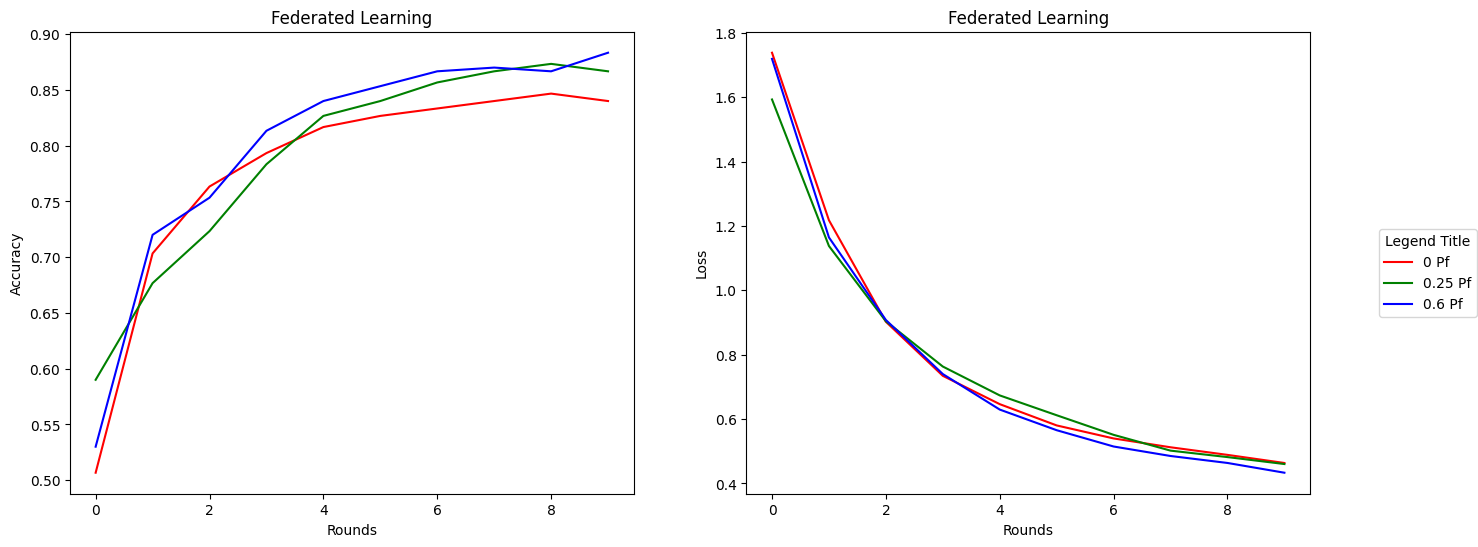

In [4]:
r1, ga1, gl1 = FL(NCLIENTS=10,ROUNDS=10,PROBFAIL=0,OVERLAPPING_ENTRIES_PERCENT=0,RANDOM_TRAINING_ENTRIES=False,CHAOTIC_ENTRIES=40,TRAIN_SIZE=700,TEST_SIZE=300)
r2, ga2, gl2 = FL(NCLIENTS=10,ROUNDS=10,PROBFAIL=0.25,OVERLAPPING_ENTRIES_PERCENT=0,RANDOM_TRAINING_ENTRIES=False,CHAOTIC_ENTRIES=40,TRAIN_SIZE=700,TEST_SIZE=300)
r3, ga3, gl3 = FL(NCLIENTS=10,ROUNDS=10,PROBFAIL=0.6,OVERLAPPING_ENTRIES_PERCENT=0,RANDOM_TRAINING_ENTRIES=False,CHAOTIC_ENTRIES=40,TRAIN_SIZE=700,TEST_SIZE=300)


fig, axs = plt.subplots(1,2, figsize=(16,6))
line_labels = ['0 Pf','0.25 Pf','0.6 Pf']

axs[0].title.set_text(f'Federated Learning')
axs[0].set_xlabel('Rounds')
axs[0].set_ylabel('Accuracy')
l1 = axs[0].plot(r1,ga1, color='red')[0]
l2 = axs[0].plot(r2,ga2, color='green')[0]
l3 = axs[0].plot(r3,ga3, color='blue')[0]

axs[1].title.set_text(f'Federated Learning')
axs[1].set_xlabel('Rounds')
axs[1].set_ylabel('Loss')
l1 = axs[1].plot(r1,gl1, color='red')[0]
l2 = axs[1].plot(r2,gl2, color='green')[0]
l3 = axs[1].plot(r3,gl3, color='blue')[0]

# Create the legend
fig.legend([l1, l2, l3],     # The line objects
           labels=line_labels,   # The labels for each line
           loc="center right",   # Position of legend
           borderaxespad=0.1,    # Small spacing around legend box
           title="Legend Title"  # Title for the legend
           )

Total clients: 10 total.
------Round 0------
Active clients: 10 / 10 total.
Round 0.GLOBAL ACC: 0.5766666531562805
------Round 1------
Active clients: 10 / 10 total.
Round 1.GLOBAL ACC: 0.7400000095367432
------Round 2------
Active clients: 10 / 10 total.
Round 2.GLOBAL ACC: 0.8033333420753479
------Round 3------
Active clients: 10 / 10 total.
Round 3.GLOBAL ACC: 0.8233333230018616
------Round 4------
Active clients: 10 / 10 total.
Round 4.GLOBAL ACC: 0.846666693687439
------Round 5------
Active clients: 10 / 10 total.
Round 5.GLOBAL ACC: 0.8533333539962769
------Round 6------
Active clients: 10 / 10 total.
Round 6.GLOBAL ACC: 0.8700000047683716
------Round 7------
Active clients: 10 / 10 total.
Round 7.GLOBAL ACC: 0.8733333349227905
------Round 8------
Active clients: 10 / 10 total.
Round 8.GLOBAL ACC: 0.8700000047683716
------Round 9------
Active clients: 10 / 10 total.
Round 9.GLOBAL ACC: 0.8766666650772095
Total clients: 10 total.
------Round 0------
Active clients: 10 / 10 total.


C:\Users\lucas\AppData\Local\Temp\ipykernel_106884\2785700756.py:24: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([l1, l2, l3],     # The line objects


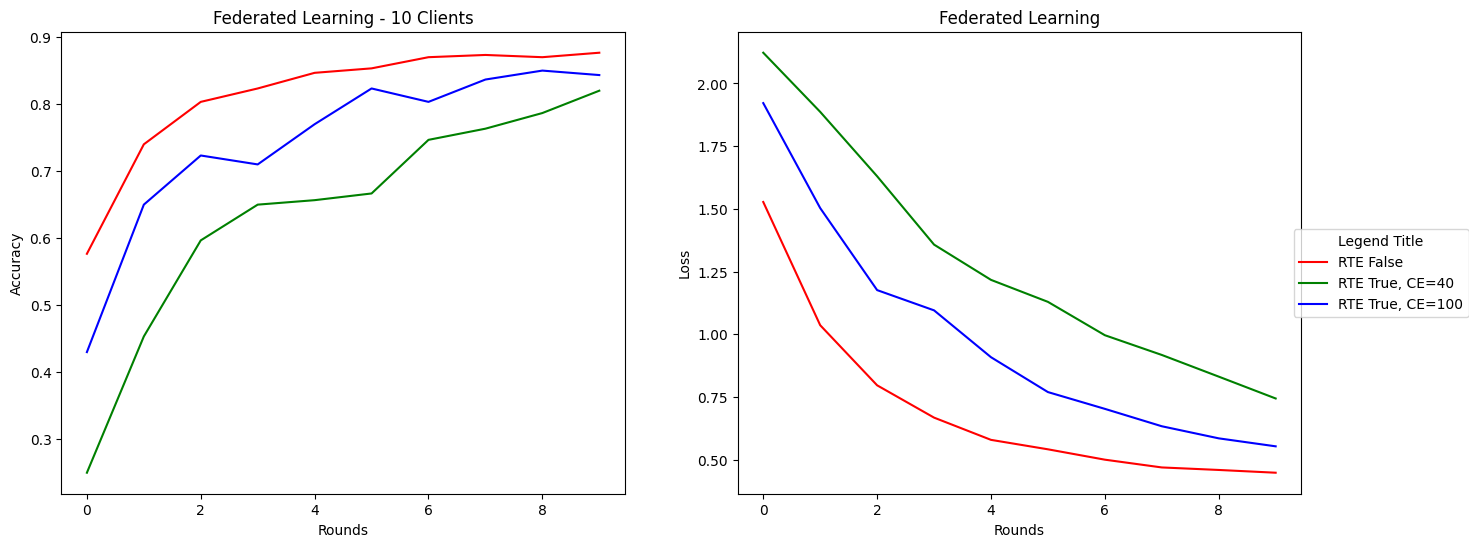

In [6]:
r1, ga1, gl1 = FL(NCLIENTS=10,ROUNDS=10,PROBFAIL=0,OVERLAPPING_ENTRIES_PERCENT=0,RANDOM_TRAINING_ENTRIES=False,CHAOTIC_ENTRIES=40,TRAIN_SIZE=700,TEST_SIZE=300)
r2, ga2, gl2 = FL(NCLIENTS=10,ROUNDS=10,PROBFAIL=0,OVERLAPPING_ENTRIES_PERCENT=0,RANDOM_TRAINING_ENTRIES=True,CHAOTIC_ENTRIES=40,TRAIN_SIZE=700,TEST_SIZE=300)
r3, ga3, gl3 = FL(NCLIENTS=10,ROUNDS=10,PROBFAIL=0,OVERLAPPING_ENTRIES_PERCENT=0,RANDOM_TRAINING_ENTRIES=True,CHAOTIC_ENTRIES=80,TRAIN_SIZE=700,TEST_SIZE=300)


fig, axs = plt.subplots(1,2, figsize=(16,6))
line_labels = ['RTE False','RTE True, CE=40','RTE True, CE=100']

axs[0].title.set_text(f'Federated Learning - 10 Clients')
axs[0].set_xlabel('Rounds')
axs[0].set_ylabel('Accuracy')
l1 = axs[0].plot(r1,ga1, color='red')[0]
l2 = axs[0].plot(r2,ga2, color='green')[0]
l3 = axs[0].plot(r3,ga3, color='blue')[0]

axs[1].title.set_text(f'Federated Learning')
axs[1].set_xlabel('Rounds')
axs[1].set_ylabel('Loss')
l1 = axs[1].plot(r1,gl1, color='red')[0]
l2 = axs[1].plot(r2,gl2, color='green')[0]
l3 = axs[1].plot(r3,gl3, color='blue')[0]

# Create the legend
fig.legend([l1, l2, l3],     # The line objects
           labels=line_labels,   # The labels for each line
           loc="center right",   # Position of legend
           borderaxespad=0.1,    # Small spacing around legend box
           title="Legend Title"  # Title for the legend
           )

Total clients: 10 total.
------Round 0------
Active clients: 10 / 10 total.
Round 0.GLOBAL ACC: 0.5400000214576721
------Round 1------
Active clients: 10 / 10 total.
Round 1.GLOBAL ACC: 0.6866666674613953
------Round 2------
Active clients: 10 / 10 total.
Round 2.GLOBAL ACC: 0.753333330154419
------Round 3------
Active clients: 10 / 10 total.
Round 3.GLOBAL ACC: 0.7933333516120911
------Round 4------
Active clients: 10 / 10 total.
Round 4.GLOBAL ACC: 0.8133333325386047
------Round 5------
Active clients: 10 / 10 total.
Round 5.GLOBAL ACC: 0.8333333134651184
------Round 6------
Active clients: 10 / 10 total.
Round 6.GLOBAL ACC: 0.8433333039283752
------Round 7------
Active clients: 10 / 10 total.
Round 7.GLOBAL ACC: 0.8433333039283752
------Round 8------
Active clients: 10 / 10 total.
Round 8.GLOBAL ACC: 0.8600000143051147
------Round 9------
Active clients: 10 / 10 total.
Round 9.GLOBAL ACC: 0.8633333444595337
Total clients: 10 total.
------Round 0------
Active clients: 10 / 10 total.


C:\Users\lucas\AppData\Local\Temp\ipykernel_106884\1072909920.py:24: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([l1, l2, l3],     # The line objects


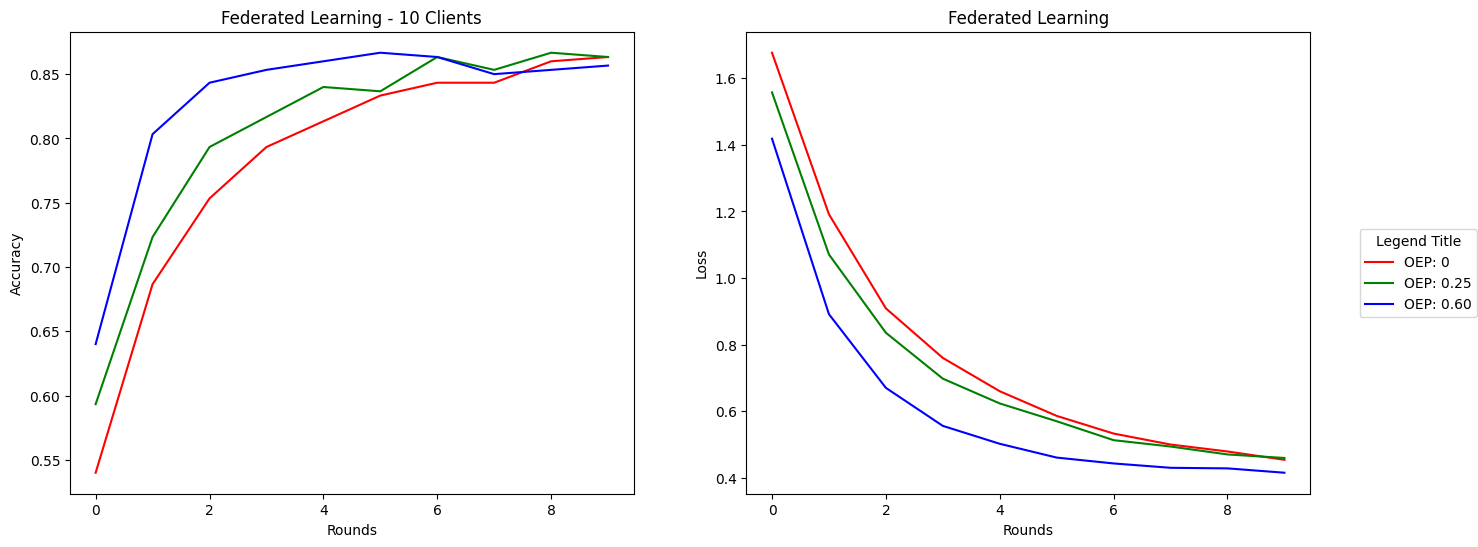

In [9]:
r1, ga1, gl1 = FL(NCLIENTS=10,ROUNDS=10,PROBFAIL=0,OVERLAPPING_ENTRIES_PERCENT=0,RANDOM_TRAINING_ENTRIES=False,CHAOTIC_ENTRIES=40,TRAIN_SIZE=700,TEST_SIZE=300)
r2, ga2, gl2 = FL(NCLIENTS=10,ROUNDS=10,PROBFAIL=0,OVERLAPPING_ENTRIES_PERCENT=0.25,RANDOM_TRAINING_ENTRIES=False,CHAOTIC_ENTRIES=40,TRAIN_SIZE=700,TEST_SIZE=300)
r3, ga3, gl3 = FL(NCLIENTS=10,ROUNDS=10,PROBFAIL=0,OVERLAPPING_ENTRIES_PERCENT=0.60,RANDOM_TRAINING_ENTRIES=False,CHAOTIC_ENTRIES=80,TRAIN_SIZE=700,TEST_SIZE=300)


fig, axs = plt.subplots(1,2, figsize=(16,6))
line_labels = ['OEP: 0','OEP: 0.25','OEP: 0.60']

axs[0].title.set_text(f'Federated Learning - 10 Clients')
axs[0].set_xlabel('Rounds')
axs[0].set_ylabel('Accuracy')
l1 = axs[0].plot(r1,ga1, color='red')[0]
l2 = axs[0].plot(r2,ga2, color='green')[0]
l3 = axs[0].plot(r3,ga3, color='blue')[0]

axs[1].title.set_text(f'Federated Learning')
axs[1].set_xlabel('Rounds')
axs[1].set_ylabel('Loss')
l1 = axs[1].plot(r1,gl1, color='red')[0]
l2 = axs[1].plot(r2,gl2, color='green')[0]
l3 = axs[1].plot(r3,gl3, color='blue')[0]

# Create the legend
fig.legend([l1, l2, l3],     # The line objects
           labels=line_labels,   # The labels for each line
           loc="center right",   # Position of legend
           borderaxespad=0.1,    # Small spacing around legend box
           title="Legend Title"  # Title for the legend
           )

In [ ]:
# m1 = Sequential()
# m1.add(Dense(units=32, activation='relu', input_dim=784))
# m1.add(Dense(units=10, activation='softmax'))

# m1.get_weights()

# m2 = Sequential()
# m2.add(Dense(units=32, activation='relu', input_dim=784))
# m2.add(Dense(units=10, activation='softmax'))

# m2.get_weights()

In [ ]:
# print(m1.get_weights()[0].shape)
# print(m1.get_weights()[1].shape)
# print(m1.get_weights()[2].shape)
# print(m1.get_weights()[3].shape)
    
# m1.get_weights()[0] + m2.get_weights()[0]


# # print(m1.get_weights()[0].shape)
# # print(m1.get_weights()[1].shape)

In [ ]:
# np.sum([m1.get_weights()[0], m2.get_weights()[0]], axis=0)

In [ ]:
# v1 = [1,2,3,4,5]
# v2 = [6,7,8,9,10]
# v3 = [11,12,13,14,15]
# v = [v1,v2,v3]

# for z in zip(*v):
#     print(z)
#     print(np.sum(z,axis=0))

In [ ]:
# sample_len = random.randint(1, len(v1))
# random.sample(v1,sample_len)

# r = random.sample([z for z in zip(v1,v2)], sample_len)
# print(r)
# [el[1] for el in r]

In [ ]:
# len(X_train[0:10])

In [ ]:
# sample_len = random.randint(1, 2)
# r = random.sample([z for z in zip(X_train,y_train)], sample_len)
# print(r)

In [ ]:
# import tensorflow as tf
# if tf.test.gpu_device_name():
#     print('GPU encontrada')
# else:
#     print("GPU não encontrada")
    
# # Configuração do uso da GPU
# physical_devices = tf.config.experimental.list_physical_devices()
# print(physical_devices)
# with tf.device('/GPU:0'):
#     print("Olá")

# !nvidia-smi